In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import nltk
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('xor.csv')
print(df.head())

   Unnamed: 0        X1        X2  label
0           0  0.295740  0.084965    0.0
1           1  0.071516  0.281896    0.0
2           2  0.167992  0.242829    0.0
3           3  0.007919  0.481756    0.0
4           4  0.100156  0.447592    0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1000 non-null   int64  
 1   X1          1000 non-null   float64
 2   X2          1000 non-null   float64
 3   label       1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 31.4 KB


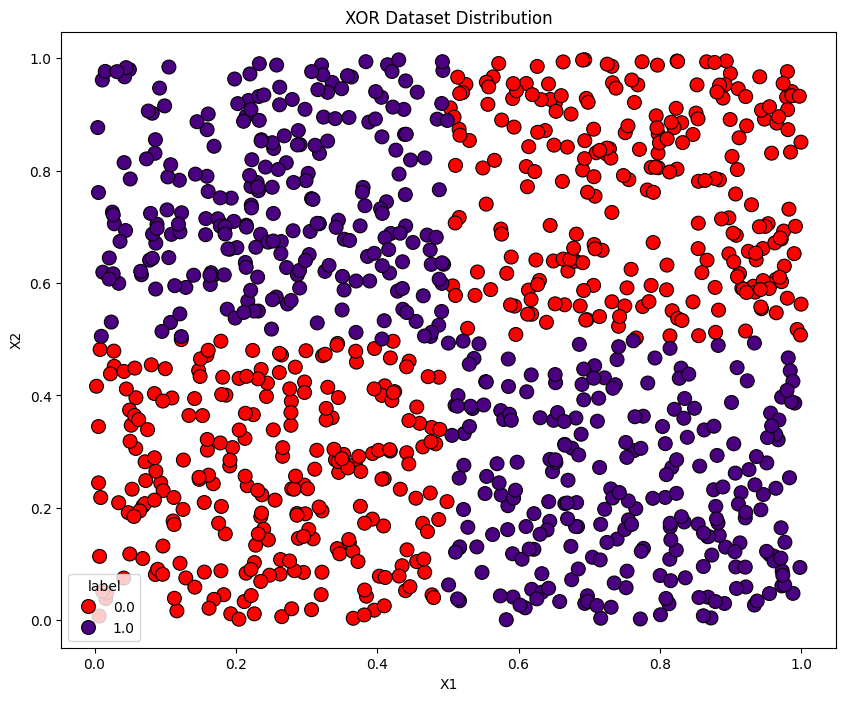

In [4]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=df, x="X1", y="X2", hue="label", palette={0: "red", 1: "indigo"}, s=100, edgecolor="black")
plt.title("XOR Dataset Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [5]:
df_X = df[['X1','X2']]
df_Y = df['label']

Point to note : Here gradient means differentiation

In [6]:
# Super class
class Layer:

  def __init__(self):
    self.input = None
    self.output = None

  def forward_pass(self,input):
    pass

  def backward_pass(self, output_gradient,l_rate):
    pass

In [7]:
# Child class for dense layers (include input, hidden, and output also)
class DenseLayer(Layer):

  def __init__(self, input_size,output_size):
    self.weights = np.random.randn(output_size,input_size)
    self.bias = np.random.randn(output_size,1);

  def forward_pass(self, input):
    self.input = input;
    return np.dot(self.weights,self.input) + self.bias

  def backward_pass(self, output_gradient, l_rate):
    weights_gradient = np.dot(output_gradient, self.input.T)
    self.weights -= l_rate*weights_gradient
    self.bias -= l_rate*output_gradient
    return np.dot(self.weights.T, output_gradient)


In [8]:
# Child class for Activation layer for the output tranformation from the dense layer
class ActivationLayer(Layer):

  def __init__(self, activation, activation_gradient):
    self.activation = activation
    self.activation_gradient = activation_gradient

  def forward_pass(self, input):
    self.input = input
    return self.activation(self.input)

  def backward_pass(self, output_gradient, l_rate):
    return np.multiply(output_gradient, self.activation_gradient(self.input))

In [9]:
# Child-Child class for tanh Activation Layer : tanh(x)
class Tanh(ActivationLayer):
  def __init__(self):
    tanh = lambda x : np.tanh(x)
    tanh_gradient = lambda x : 1 - np.tanh(x)**2
    super().__init__(tanh,tanh_gradient)

In [10]:
# Child-Child class for sigmoid Activation Layer: (1 / (1 + e^(-x)))
class Sigmoid(ActivationLayer):
    def __init__(self):
        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        sigmoid_gradient = lambda x: sigmoid(x) * (1 - sigmoid(x))
        super().__init__(sigmoid, sigmoid_gradient)

In [11]:
# Mean Squarred Error

def mean_squared_error(y_true, y_pred):
  return np.mean(np.power(y_true - y_pred, 2))
def mean_squared_error_gradient(y_true, y_pred):
  return 2*(y_pred - y_true)/np.size(y_true)

In [12]:
# This was done as the dataset is ordered as first half as all zeroes and other with 1 as label

X = df_X.to_numpy()
X = np.reshape(X,(np.size(X,0),np.size(X,1),1))
Y = df_Y.to_numpy()
Y = np.reshape(Y,(np.size(Y),1,1))
# print(X)
# print(Y)
print(X.shape)
print(Y.shape)

# To shuffle the database
indices = np.arange(len(X))
np.random.seed(42)
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

(1000, 2, 1)
(1000, 1, 1)


In [16]:
from sklearn.model_selection import KFold
import numpy as np


epochs = 3000
learning_rate = 0.1
k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_errors = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold: {fold+1}/{k_folds}")

    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # mlp model can be changed but dimensions should match between Dense layer
    mlp = [
      DenseLayer(2,3),
      Tanh(),
      DenseLayer(3,2),
      Sigmoid(),
      DenseLayer(2,1),
      Sigmoid()
    ]

    for e in range(epochs):
        error = 0

        for x, y in zip(X_train, Y_train):
            # Forward Pass
            input = x
            for layer in mlp:
                input = layer.forward_pass(input)
            output = input

            # Error calculation (M.S.E)
            error += mean_squared_error(y, output)

            # Backward Pass
            gradient = mean_squared_error_gradient(y, output)
            for layer in reversed(mlp):
                gradient = layer.backward_pass(gradient, learning_rate)

        error /= len(X_train)

        # Printing training error rate
        if (e + 1) % 1000 == 0:
            print(f"Epoch: {e+1}, Training Error: {error:.5f}")


    # Testing on test data
    correct_predictions = 0
    val_error = 0
    for x, y in zip(X_val, Y_val):
        input = x
        for layer in mlp:
            input = layer.forward_pass(input)
        output = input
        predicted_label = 1 if output >= 0.5 else 0
        if predicted_label == y:
            correct_predictions += 1
        val_error += mean_squared_error(y, output)

    # Printing testing error rate
    accuracy = (correct_predictions / len(Y_val)) * 100
    val_error /= len(X_val)
    print(f"Fold: {fold+1} Validation Error: {val_error:.5f}, Validation Accuracy: {accuracy:.2f}%")
    fold_errors.append(val_error)


# Calculate average of all the folds error
avg_val_error = np.mean(fold_errors)
print(f"\nAverage Validation Error Across {k_folds} Folds : {avg_val_error:.5f}")


Fold: 1/5
Epoch: 1000, Training Error: 0.00892
Epoch: 2000, Training Error: 0.00893
Epoch: 3000, Training Error: 0.00811
Fold: 1 Validation Error: 0.00507, Validation Accuracy: 99.50%
Fold: 2/5
Epoch: 1000, Training Error: 0.01216
Epoch: 2000, Training Error: 0.00526
Epoch: 3000, Training Error: 0.00469
Fold: 2 Validation Error: 0.00519, Validation Accuracy: 99.50%
Fold: 3/5
Epoch: 1000, Training Error: 0.05671
Epoch: 2000, Training Error: 0.05269
Epoch: 3000, Training Error: 0.06688
Fold: 3 Validation Error: 0.05951, Validation Accuracy: 91.00%
Fold: 4/5
Epoch: 1000, Training Error: 0.01801
Epoch: 2000, Training Error: 0.00890
Epoch: 3000, Training Error: 0.00484
Fold: 4 Validation Error: 0.00797, Validation Accuracy: 99.00%
Fold: 5/5
Epoch: 1000, Training Error: 0.00475
Epoch: 2000, Training Error: 0.01060
Epoch: 3000, Training Error: 0.00390
Fold: 5 Validation Error: 0.01385, Validation Accuracy: 98.50%

Average Validation Error Across 5 Folds : 0.01832


In [17]:
from sklearn.model_selection import KFold
import numpy as np


epochs = 3000
learning_rate = 0.1
k_folds = 5

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

fold_errors = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f"Fold: {fold+1}/{k_folds}")

    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # mlp model can be changed but dimensions should match between Dense layer
    mlp = [
      DenseLayer(2,4),
      Tanh(),
      DenseLayer(4,1),
      Sigmoid()
    ]

    for e in range(epochs):
        error = 0

        for x, y in zip(X_train, Y_train):
            # Forward Pass
            input = x
            for layer in mlp:
                input = layer.forward_pass(input)
            output = input

            # Error calculation (M.S.E)
            error += mean_squared_error(y, output)

            # Backward Pass
            gradient = mean_squared_error_gradient(y, output)
            for layer in reversed(mlp):
                gradient = layer.backward_pass(gradient, learning_rate)

        error /= len(X_train)

        # Printing training error rate
        if (e + 1) % 1000 == 0:
            print(f"Epoch: {e+1}, Training Error: {error:.5f}")


    # Testing on test data
    correct_predictions = 0
    val_error = 0
    for x, y in zip(X_val, Y_val):
        input = x
        for layer in mlp:
            input = layer.forward_pass(input)
        output = input
        predicted_label = 1 if output >= 0.5 else 0
        if predicted_label == y:
            correct_predictions += 1
        val_error += mean_squared_error(y, output)

    # Printing testing error rate
    accuracy = (correct_predictions / len(Y_val)) * 100
    val_error /= len(X_val)
    print(f"Fold: {fold+1} Validation Error: {val_error:.5f}, Validation Accuracy: {accuracy:.2f}%")
    fold_errors.append(val_error)


# Calculate average of all the folds error
avg_val_error = np.mean(fold_errors)
print(f"\nAverage Validation Error Across {k_folds} Folds : {avg_val_error:.5f}")


Fold: 1/5
Epoch: 1000, Training Error: 0.01688
Epoch: 2000, Training Error: 0.01996
Epoch: 3000, Training Error: 0.02633
Fold: 1 Validation Error: 0.02063, Validation Accuracy: 97.00%
Fold: 2/5
Epoch: 1000, Training Error: 0.01768
Epoch: 2000, Training Error: 0.01697
Epoch: 3000, Training Error: 0.01611
Fold: 2 Validation Error: 0.01126, Validation Accuracy: 98.50%
Fold: 3/5
Epoch: 1000, Training Error: 0.04133
Epoch: 2000, Training Error: 0.03782
Epoch: 3000, Training Error: 0.03806
Fold: 3 Validation Error: 0.04230, Validation Accuracy: 94.00%
Fold: 4/5
Epoch: 1000, Training Error: 0.01924
Epoch: 2000, Training Error: 0.01572
Epoch: 3000, Training Error: 0.01663
Fold: 4 Validation Error: 0.01694, Validation Accuracy: 98.00%
Fold: 5/5
Epoch: 1000, Training Error: 0.01751
Epoch: 2000, Training Error: 0.01544
Epoch: 3000, Training Error: 0.01430
Fold: 5 Validation Error: 0.03509, Validation Accuracy: 97.00%

Average Validation Error Across 5 Folds : 0.02524
